# Creating Readmission Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# Text Processing
import re

In [2]:
admissions = pd.read_csv("./Data/ADMISSIONS.csv", index_col = None)
patients = pd.read_csv("./Data/PATIENTS.csv", index_col = None)

In [3]:
# Convert all the date columns
admissions.ADMITTIME = pd.to_datetime(admissions.ADMITTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
admissions.DISCHTIME = pd.to_datetime(admissions.DISCHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
admissions.DEATHTIME = pd.to_datetime(admissions.DEATHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

patients.DOB = pd.to_datetime(patients.DOB, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

In [4]:
# Let us sort the dataframe on admittime and subjectid to see how a post admission journey looks like
admissions = admissions.sort_values(['SUBJECT_ID','ADMITTIME'])
admissions.reset_index(drop = True, inplace = True)

Text(0, 0.5, 'Count of Patients')

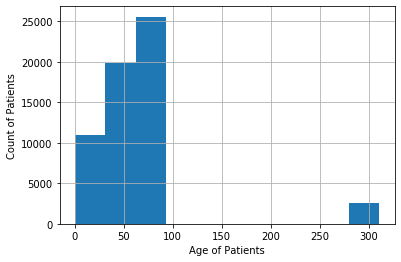

In [5]:
# Since we already have the patient's admit time and DOB from patients table let us calculate a patient's age
patient_age = {row[1]: row[2] for row in patients[['SUBJECT_ID','DOB']].itertuples()}
admissions["AGE"] = [int((adm_time.date() - patient_age[subj_id].date()).days/365) 
                     for adm_time, subj_id in zip(admissions["ADMITTIME"], admissions["SUBJECT_ID"])]

age_plot = admissions.AGE.hist()
age_plot.set_xlabel('Age of Patients')
age_plot.set_ylabel('Count of Patients')

In [6]:
# The above histogram shows us that that more or less the age is spread upto 100, but there are a lot of patients with age of 300. 
# Don't be confused this is just because for patients with age >89 are replaced with 300 in the MIMIC III dataset due to HIPPA

# Let us randomly spread these patients within age range of 90 to 100
admissions.loc[admissions.AGE >= 300,"AGE"] = random.choices(list(range(90,100)),k = sum(admissions.AGE >= 300))

# We will also remove all the young patients as chance of readmission is quite low due to rare chance of comorbidity and good general health
# This will also help us to remove imablance between positive and negative class
admissions = admissions[admissions.AGE >18]

In [7]:
def normalize_ethnicity(x):
    """
    Helper Function to Normalize Ethnicity into "WHITE", "HISPANIC", "ASIAN", "BLACK" and "OTHERS"
    """
    if "WHITE" in x:
        return "WHITE"
    elif "HISPANIC" in x:
        return "HISPANIC"
    elif "ASIAN" in x:
        return "ASIAN"
    elif "BLACK" in x:
        "BLACK"
    else:
        return "OTHERS"

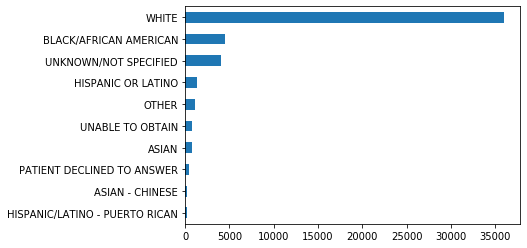

In [8]:
admissions.ETHNICITY.value_counts().head(10).sort_values().plot(kind = "barh")

In [9]:
# Next, Let us normalize Ethnicity for the same reason to get substantial support for different categories and we don't end up having
# a very sparse data
admissions.ETHNICITY.value_counts()
admissions.ETHNICITY = admissions.ETHNICITY.apply(lambda x: normalize_ethnicity(x) if pd.notnull(x) else x)


In [10]:
def normalize_discharge(x):
    """
    Helper Function to Normalize Discharge Location into "HOME", "MEDICAL_FACILITY", and "OTHERS"
    """
    if "HOME" in x:
        return "HOME"
    elif len(re.findall("OTHER|DEAD",x)) > 0:
        return "OTHER"
    else:
        return "MEDICAL_FACILITY"  

In [11]:
# Let us club Discharge location into three categories Medical Facility, Home and Others. This will help us maintain a significant count
# For each category 
# Let us Quickly see unique Discharge Locations
admissions.DISCHARGE_LOCATION.value_counts()
admissions.DISCHARGE_LOCATION = admissions.DISCHARGE_LOCATION.apply(lambda x: normalize_discharge(x) if pd.notnull(x) else x)


In [12]:
# Discharge Duration
admissions["DISCHARGE_DURATION"] = (admissions["DISCHTIME"] - admissions["ADMITTIME"]).dt.total_seconds()/(24*60*60)

In [13]:
# Calculating Days Until Next Admission
# Step 1:- Add the next Admit Time
admissions = admissions.sort_values(['SUBJECT_ID','ADMITTIME']) #make sure the admittime is sorted before the shift operation
admissions['NEXT_ADMITTIME'] = admissions.groupby('SUBJECT_ID').ADMITTIME.shift(-1)

# Step 2:- Subtract Discharge Time from Next Admit Time
admissions['DAYS_NEXT_ADMIT']=  (admissions.NEXT_ADMITTIME - admissions.DISCHTIME).dt.total_seconds()/(24*60*60)

In [14]:
admissions["IS_READMISSION"] = admissions.DAYS_NEXT_ADMIT.apply(lambda x: 0 if pd.isnull(x) else (0 if x >30 else 1))

In [15]:
# Lastly we will remove those any death related admission event.
admissions = admissions[admissions.HOSPITAL_EXPIRE_FLAG == 0].reset_index(drop = True)

In [16]:
# 1) We need only Unplanned medical care and our patient cohort should not represent new borns hence we will filter out
# "ELECTIVE" and "NEWBORN"
admissions.ADMISSION_TYPE.value_counts()
admissions = admissions[~admissions.ADMISSION_TYPE.isin(["ELECTIVE", "NEWBORN"])].reset_index(drop = True)

In [17]:
admissions = admissions[["SUBJECT_ID", "HADM_ID", "AGE", "ADMISSION_TYPE","DISCHARGE_DURATION","DISCHARGE_LOCATION","INSURANCE","ETHNICITY","IS_READMISSION","ADMITTIME"]]

In [18]:
admissions = pd.merge(admissions, patients[["SUBJECT_ID","GENDER"]], how="left", on = "SUBJECT_ID")

In [19]:
icustays = pd.read_csv("./Data/ICUSTAYS.csv", index_col = None)
transfers = pd.read_csv("./Data/TRANSFERS.csv", index_col = None)

In [20]:
# Convert all the date columns
icustays.INTIME = pd.to_datetime(icustays.INTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
icustays.OUTTIME = pd.to_datetime(icustays.OUTTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

In [21]:
transfers.dropna(subset=["ICUSTAY_ID"], inplace = True)
transfers.ICUSTAY_ID = transfers.ICUSTAY_ID.astype(int)

In [22]:
transfers.EVENTTYPE.value_counts()

transfer    55186
admit       32535
Name: EVENTTYPE, dtype: int64

In [23]:
transfers_num = transfers.groupby(["SUBJECT_ID","HADM_ID","ICUSTAY_ID"])['EVENTTYPE'].apply(lambda x : sum(x=="transfer")).reset_index()

In [24]:
transfers_num.columns = ["SUBJECT_ID","HADM_ID","ICUSTAY_ID", "NUM_TRANSFERS"]

In [25]:
# Updating ICU Data with number of transfer a patient undergoes once admitted
# Higher number of transfers translates to higher serious risk at the patient's end
# But this is just number of transfers happened within 24hrs of first ICU admission
icustays = pd.merge(icustays, transfers_num, on=["SUBJECT_ID","HADM_ID","ICUSTAY_ID"], how="left")

In [26]:
# Making sure that if a key is not found then number of transfers for that key automatically becomes 0
icustays.NUM_TRANSFERS.fillna(0, inplace = True)

# ICU Transfers within 24hrs for a unique hospital admission
icustays_transfers_num = icustays.groupby(["SUBJECT_ID","HADM_ID"])["NUM_TRANSFERS"].sum().reset_index()

In [27]:
# ICU Transfers across days for a unique hospital admission
icustays_num = icustays.groupby(["SUBJECT_ID","HADM_ID"])["ICUSTAY_ID"].nunique().reset_index()
icustays_num.columns = ["SUBJECT_ID","HADM_ID","ICU_TRANSFERS"]

# Average Length of stay in ICU for a patient
icustays_avg_los = icustays.groupby(["SUBJECT_ID","HADM_ID"])["LOS"].mean().reset_index()

# We should also get the first care unit for the admission
icustays = icustays.sort_values(['SUBJECT_ID','HADM_ID','INTIME'])
icustays_firstcare = icustays.groupby(['SUBJECT_ID','HADM_ID'])['FIRST_CAREUNIT'].nth(0).reset_index()

In [28]:
import functools
_dfs = [icustays_num, icustays_avg_los, icustays_transfers_num, icustays_firstcare]
icustays_final = functools.reduce(lambda left,right: pd.merge(left,right,on=["SUBJECT_ID","HADM_ID"], how="inner"), _dfs)

In [29]:
icustays_transfers_num.reset_index()

,index,SUBJECT_ID,HADM_ID,NUM_TRANSFERS
0,0,2,163353,1
1,1,3,145834,0
2,2,4,185777,0
3,3,5,178980,1
4,4,6,107064,1
...,...,...,...,...
57781,57781,99985,176670,3
57782,57782,99991,151118,1
57783,57783,99992,197084,0
57784,57784,99995,137810,1


In [30]:
icustays_final["TOTAL_TRANSFERS"] = icustays_final["ICU_TRANSFERS"] + icustays_final["NUM_TRANSFERS"]

In [31]:
# WE will drop any Neo (New Born) related ICU visits, https://mimic.physionet.org/mimictables/transfers/
icustays_final = icustays_final[~icustays_final.FIRST_CAREUNIT.isin(["NICU","NWARD"])].reset_index(drop = True).drop(["NUM_TRANSFERS","ICU_TRANSFERS"], axis = 1)

In [32]:
# It's time to move to patients clincal and lab data
# These are large files and hence we need a smarter a way to ingest them into our space. 
# Also since we don't need full data we will iterate using chunking a in-built feature of pandas library

In [33]:
dictionary_itemid = pd.read_csv("./Data/D_ITEMS.csv", index_col = None)
dictionary_itemid.dropna(subset=["LABEL"], inplace = True)

# We only need those ITEM IDs which links to chart events
dictionary_itemid = dictionary_itemid[dictionary_itemid.LINKSTO.isin(["chartevents"])]

In [34]:
# To get the item-ids, follow these steps
# Step 1:- Make a combination of words you expect to show up as description
# Step 2:- Use your Domain Knowledge to filter down the ITEMIDs
dictionary_itemid[[ True if ("sys" in x.lower() and len(re.findall("bp|blood pressure|blood",x.lower())) > 0) else False for x in dictionary_itemid.LABEL]]
sys_bp_itemids = [51, 442, 6701, 220050, 220179]

dictionary_itemid[[ True if ("dia" in x.lower() and len(re.findall("bp|blood pressure|blood",x.lower())) > 0) else False for x in dictionary_itemid.LABEL]]
dia_bp_itemids = [8368, 8440, 8555, 220051, 220180]

dictionary_itemid[[ True if ("resp" in x.lower() and len(re.findall("rate",x.lower())) > 0) else False for x in dictionary_itemid.LABEL]]
respr_itemids = [615, 618, 3603, 224690, 220210]

dictionary_itemid[[ True if ("glucose" in x.lower()) else False for x in dictionary_itemid.LABEL]]
glucose_itemids = [1455, 1310, 807, 811, 3744, 3745, 1529, 2338, 225664, 220621, 226537]

# Similarly
heartrate_itemids = [211, 220045]
temp_itemids = [676, 678, 223761, 223762]

In [35]:
# Using the same idea we will get a short list of itemids for the list of lab events we are using
dictionary_labitemid = pd.read_csv("./Data/D_LABITEMS.csv", index_col = None)

dictionary_labitemid.dropna(subset=["LABEL","FLUID"], inplace = True)
dictionary_labitemid["DEFINITION"] = dictionary_labitemid["LABEL"] + " " +dictionary_labitemid["FLUID"]

In [36]:
hadm_filter = icustays_final.HADM_ID.tolist()
total_itemids = sys_bp_itemids+dia_bp_itemids+respr_itemids+glucose_itemids+temp_itemids+heartrate_itemids
total_labitems = [51265, 51221, 50862, 50983, 50971, 50893]
n_rows = 100000

# create the iterator
labevents_iterator = pd.read_csv(
    "./Data/LABEVENTS.csv",
    iterator=True,
    chunksize=n_rows)

# concatenate according to a filter to get our labevents data
labevents = pd.concat(
    [labevent_chunk[np.logical_and(labevent_chunk['HADM_ID'].isin(hadm_filter),
                                  labevent_chunk['ITEMID'].isin(total_labitems))]if str(labevent_chunk.HADM_ID.dtype) == 'int64'
                   else labevent_chunk[np.logical_and(labevent_chunk['HADM_ID'].isin([float(x) for x in hadm_filter]),
                                                      labevent_chunk['ITEMID'].isin(total_labitems))]
    for labevent_chunk in labevents_iterator])

# create the iterator
chartevents_iterator = pd.read_csv(
    "./Data/CHARTEVENTS.csv",
    iterator=True,
    chunksize=n_rows,
    usecols = ["SUBJECT_ID", "HADM_ID", "ICUSTAY_ID", "ITEMID", "VALUE", "VALUENUM", "VALUEUOM"])

# concatenate according to a filter to get our labevents data
chartevents = pd.concat(
    [chartevent_chunk[np.logical_and(chartevent_chunk['HADM_ID'].isin(hadm_filter),
                                    chartevent_chunk['ITEMID'].isin(total_itemids))] if str(chartevent_chunk.HADM_ID.dtype) == 'int64'
                   else chartevent_chunk[np.logical_and(chartevent_chunk['HADM_ID'].isin([float(x) for x in hadm_filter]),
                                                       chartevent_chunk['ITEMID'].isin(total_itemids))]
    for chartevent_chunk in chartevents_iterator])

In [37]:
chartevents.dropna(axis = 0, subset = ["VALUENUM"], inplace = True)

In [38]:
chartevents.drop('VALUE', axis = 1, inplace = True)

In [39]:
# Since the data is collected from two different systems let us check for units for each of our patients clinical data
print("Systolic BP :- ",chartevents[chartevents.ITEMID.isin(sys_bp_itemids)].VALUEUOM.unique())
print("Diastolic BP :- ",chartevents[chartevents.ITEMID.isin(dia_bp_itemids)].VALUEUOM.unique())
print("Respiratory Rate :- ",chartevents[chartevents.ITEMID.isin(respr_itemids)].VALUEUOM.unique())
print("Glucose Levels :- ",chartevents[chartevents.ITEMID.isin(glucose_itemids)].VALUEUOM.unique())
print("Heart Rate :- ",chartevents[chartevents.ITEMID.isin(heartrate_itemids)].VALUEUOM.unique())
print("Temperature :- ",chartevents[chartevents.ITEMID.isin(temp_itemids)].VALUEUOM.unique())

Systolic BP :-  ['mmHg']
Diastolic BP :-  ['mmHg']
Respiratory Rate :-  ['insp/min' 'BPM']
Glucose Levels :-  [nan 'mg/dL']
Heart Rate :-  ['bpm' 'BPM']
Temperature :-  ['?F' '?C' 'Deg. F' 'Deg. C']


In [40]:
# Let us Replace ItemIds by their respective Chart Event Names to aid readability
mapping = {"Systolic_BP":sys_bp_itemids,
          "Diastolic_BP":dia_bp_itemids,
          "Resp_Rate":respr_itemids,
          "Glucose":glucose_itemids,
          "Heart_Rate":heartrate_itemids,
          "Temperature":temp_itemids}

item_id_map = {item_id: k for k,v in mapping.items() for item_id in v}

chartevents["ITEMID"] = chartevents["ITEMID"].replace(item_id_map)

In [41]:
# insp/min is same as BPM and hence there is no conversion required here
# and we won't impute for na for Glucose as the value are in the same range as when the unit is present
# We need to convert Farenheit to celsius.
chartevents.isnull().sum()

SUBJECT_ID          0
HADM_ID             0
ICUSTAY_ID      10991
ITEMID              0
VALUENUM            0
VALUEUOM      1361047
dtype: int64

In [42]:
cond1 = np.logical_and(np.logical_or(chartevents["VALUEUOM"] == "?F", chartevents["VALUEUOM"] == "Deg. F"),
               pd.notnull(chartevents["VALUEUOM"])).tolist()
cond2 = np.logical_or(chartevents["VALUEUOM"] != "?F", chartevents["VALUEUOM"] != "Deg. F").tolist()
condval1 = ((chartevents["VALUENUM"]-32)*5/9).tolist()
condval2= chartevents["VALUENUM"].tolist()
chartevents["VALUENUM"] = np.select([cond1, cond2], [condval1,condval2])

In [43]:
charts = chartevents.pivot_table(index=['SUBJECT_ID', 'HADM_ID'], 
                                   columns='ITEMID', values='VALUENUM', 
                                   aggfunc=[np.mean, np.std]).reset_index()

In [44]:
charts.columns = charts.columns.get_level_values(0)+'_'+charts.columns.get_level_values(1)

In [45]:
charts.isnull().sum()

SUBJECT_ID_              0
HADM_ID_                 0
mean_Diastolic_BP    10988
mean_Glucose           610
mean_Heart_Rate        111
mean_Resp_Rate         134
mean_Systolic_BP     10981
mean_Temperature       241
std_Diastolic_BP     11215
std_Glucose           2557
std_Heart_Rate         121
std_Resp_Rate          173
std_Systolic_BP      11212
std_Temperature        687
dtype: int64

In [46]:
charts = charts.groupby(['SUBJECT_ID_']).apply(lambda x: x.bfill())

In [47]:
charts.isnull().sum()

SUBJECT_ID_             0
HADM_ID_                0
mean_Diastolic_BP    9053
mean_Glucose          526
mean_Heart_Rate        97
mean_Resp_Rate        116
mean_Systolic_BP     9047
mean_Temperature      210
std_Diastolic_BP     9258
std_Glucose          2131
std_Heart_Rate        107
std_Resp_Rate         150
std_Systolic_BP      9255
std_Temperature       600
dtype: int64

In [48]:
charts.columns = [x[:-1] for x in charts.columns[:2]] + list(charts.columns[2:])

In [49]:
labevents.dropna(axis = 0, subset = ["HADM_ID"], inplace = True)
labevents.HADM_ID = labevents.HADM_ID.astype(int)

labevents_label = dictionary_labitemid[dictionary_labitemid.ITEMID.isin(total_labitems)]
item_id_map = dict(zip(labevents_label.ITEMID,labevents_label.LABEL))

labevents["ITEMID"] = labevents["ITEMID"].replace(item_id_map)

In [50]:
# No need to normalize units of labevents
labevents.groupby(["ITEMID"])['VALUEUOM'].apply(lambda x: set(x))

ITEMID
Albumin            {g/dL, nan}
Calcium, Total    {nan, mg/dL}
Hematocrit            {nan, %}
Platelet Count     {nan, K/uL}
Potassium         {nan, mEq/L}
Sodium            {nan, mEq/L}
Name: VALUEUOM, dtype: object

In [51]:
labs = labevents.pivot_table(index=['SUBJECT_ID', 'HADM_ID'], 
                                   columns='ITEMID', values='VALUENUM', 
                                   aggfunc=[np.mean, np.std]).reset_index()
labs.columns = labs.columns.get_level_values(0)+'_'+labs.columns.get_level_values(1)

In [52]:
labs.isnull().sum()

SUBJECT_ID_                0
HADM_ID_                   0
mean_Albumin           18840
mean_Calcium, Total     2041
mean_Hematocrit           20
mean_Platelet Count       36
mean_Potassium           148
mean_Sodium              166
std_Albumin            33285
std_Calcium, Total      5695
std_Hematocrit           891
std_Platelet Count      1000
std_Potassium           1184
std_Sodium              1277
dtype: int64

In [53]:
labs = labs.groupby(['SUBJECT_ID_']).apply(lambda x: x.bfill())

In [54]:
labs.isnull().sum()

SUBJECT_ID_                0
HADM_ID_                   0
mean_Albumin           16302
mean_Calcium, Total     1849
mean_Hematocrit           17
mean_Platelet Count       30
mean_Potassium           139
mean_Sodium              153
std_Albumin            30443
std_Calcium, Total      5083
std_Hematocrit           746
std_Platelet Count       836
std_Potassium           1026
std_Sodium              1104
dtype: int64

In [55]:
labs.columns = [x[:-1] for x in labs.columns[:2]] + list(labs.columns[2:])

## Commorbidities

-https://github.com/MIT-LCP/mimic-code/blob/master/concepts/comorbidity/elixhauser_quan.sql

-https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6381763/

In [70]:
diagnosis_icd = pd.read_csv("./Data/DIAGNOSES_ICD.csv", index_col = None)

In [71]:
mapping = {'congestive_heart_failure':['39891','40201','40211','40291','40401','40403','40411','40413','40491',
                                     '40493','4254','4255','4257','4258','4259',
                                    '428'],
       'cardiac_arrhythmias':['42613','42610','42612','99601','99604','4260','4267',
            '4269','4270','4271','4272','4273','4274','4276','4278','4279','7850','V450','V533'],
       'valvular_disease':['0932','7463','7464','7465','7466','V422','V433',
                            '394','395','396','397','424'],
       'pulmonary_circulation_disorder':['4150','4151','4170','4178','4179',
                                          '416'],
       'peripheral_vascular_disorder':['0930','4373','4431','4432','4438','4439','4471','5571','5579','V434',
                                        '440','441'],
       'hypertension':['401','402','403','404','405'],
       'paralysis':['3341','3440','3441','3442','3443','3444','3445','3446','3449',
                                     '342','343'],
       'other_neurological':['33392', 
                              '3319','3320','3321','3334','3335','3362','3481','3483','7803','7843', 
                             '334','335','340','341','345'],
       'chronic_pulmonary_disease':['4168','4169','5064','5081','5088',
                                    '490','491','492','493','494','495','496','500','501','502','503','504','505'],
       'diabetes_w_complications':['2504','2505','2506','2507','2508','2509'],
       'hypothyroidism':['2409','2461','2468', '243','244'],
       'renal_failure':['40301','40311','40391','40402','40403','40412','40413','40492','40493',
                        '5880','V420','V451',
                        '585','586','V56'],
       'liver_disease':['07022','07023','07032','07033','07044','07054',
                        '0706','0709','4560','4561','4562','5722','5723','5724','5728','5733','5734','5738','5739','V427',
                        '570','571'],
       'chronic_ulcer':['5317','5319','5327','5329','5337','5339','5347','5349'],
       'hiv_aids':['042','043','044'],
       'lymphoma':['2030','2386', '200','201','202'],
        'metastasis_solid_tumor':['140','141','142','143','144','145','146','147','148','149','150','151','152'
    ,'153','154','155','156','157','158','159','160','161','162','163','164','165'
    ,'166','167','168','169','170','171','172','174','175','176','177','178','179'
    ,'180','181','182','183','184','185','186','187','188','189','190','191','192'
    ,'193','194','195'],
       'rheumatoid_arthiritis':['72889','72930', 
                                '7010','7100','7101','7102','7103','7104','7108','7109','7112','7193','7285',
                                '446','714','720','725'],
       'coagulation_deficiency':['2871','2873','2874','2875',
                                 '286'],
       'obesity':['2780'],
       'weight_loss':['7832','7994',
                      '260','261','262','263'],
       'fluid_electrolyte_disorders':['2536','276'],
       'blood_loss_anemia':['2800'],
       'deficiency_anemia':['2801','2808','2809', '281'],
       'alcohol_abuse':['2652','2911','2912','2913','2915','2918','2919',
                                    '3030','3039','3050','3575','4255','5353','5710','5711','5712','5713','V113',
                                   '980'],
       'drug_abuse':['V6542',
                     '3052','3053','3054','3055','3056','3057','3058','3059',
                     '292','304'],
       'psychoses':['29604','29614','29644','29654','2938','295','297','298'],
       'depression':['2962','2963','2965','3004','309','311']}

mapping_score = pd.DataFrame({'congestive_heart_failure':9,
       'cardiac_arrhythmias':8,
       'valvular_disease':0,
       'pulmonary_circulation_disorder':3,
       'peripheral_vascular_disorder':4,
       'hypertension':-2,
       'paralysis':4,
       'other_neurological':5,
       'chronic_pulmonary_disease':3,
       'diabetes_w_complications':1,
       'hypothyroidism':0,
       'renal_failure':7,
       'liver_disease':7,
       'chronic_ulcer':0,
       'hiv_aids':0,
       'lymphoma':8,
        'metastasis_solid_tumor':17,
       'rheumatoid_arthiritis':0,
       'coagulation_deficiency':12,
       'obesity':-5,
       'weight_loss':10,
       'fluid_electrolyte_disorders':11,
       'blood_loss_anemia':-3,
       'deficiency_anemia':0,
       'alcohol_abuse':0,
       'drug_abuse':-11,
       'psychoses':-6,
       'depression':-5}, index = [0])

In [72]:
def get_mapping(icd_code, mapping):
    for k,v in mapping.items():
        if str(icd_code) in v:
            return k
        elif str(icd_code)[:4] in v:
            return k
        elif str(icd_code)[:3] in v:
            return k
    return None

In [73]:
diagnosis_icd["ICD9_CODE"] = diagnosis_icd.ICD9_CODE.apply(lambda x: get_mapping(x, mapping) if pd.notnull(x) else None)

In [74]:
diagnosis_icd.dropna(subset = ['ICD9_CODE'], axis =0, inplace = True)

In [75]:
diagnosis_icd = diagnosis_icd.drop_duplicates(['SUBJECT_ID', 'HADM_ID','ICD9_CODE'])[['SUBJECT_ID', 'HADM_ID','ICD9_CODE']].pivot_table(index=['SUBJECT_ID', 'HADM_ID'], 
                                   columns='ICD9_CODE',
                                   aggfunc=len, fill_value = 0).reset_index()

In [76]:
diagnosis_icd["ELIXHAUSER_SID30"] = diagnosis_icd.iloc[:,2:].multiply(np.array(mapping_score[list(diagnosis_icd.iloc[:,2:].columns)]), axis='columns').fillna(0).sum(axis = 1)

In [77]:
diagnosis_icd = diagnosis_icd[['SUBJECT_ID', 'HADM_ID','ELIXHAUSER_SID30']]

### Merging Individual Data and Filling Missing values

In [90]:
import functools
_dfs = [admissions, diagnosis_icd, charts, labs, icustays_final]
train_data = functools.reduce(lambda left,right: pd.merge(left,right,on=["SUBJECT_ID","HADM_ID"], how="inner"), _dfs)

In [91]:
train_data.isnull().sum()

SUBJECT_ID                 0
HADM_ID                    0
AGE                        0
ADMISSION_TYPE             0
DISCHARGE_DURATION         0
DISCHARGE_LOCATION         0
INSURANCE                  0
ETHNICITY               3777
IS_READMISSION             0
ADMITTIME                  0
GENDER                     0
ELIXHAUSER_SID30           0
mean_Diastolic_BP       7046
mean_Glucose             185
mean_Heart_Rate           40
mean_Resp_Rate            56
mean_Systolic_BP        7042
mean_Temperature          54
std_Diastolic_BP        7200
std_Glucose             1346
std_Heart_Rate            44
std_Resp_Rate             71
std_Systolic_BP         7197
std_Temperature          153
mean_Albumin            9488
mean_Calcium, Total      611
mean_Hematocrit            5
mean_Platelet Count        8
mean_Potassium            23
mean_Sodium               32
std_Albumin            20102
std_Calcium, Total      2162
std_Hematocrit           218
std_Platelet Count       240
std_Potassium 

In [92]:
# There are still some missing values in the final dataset, firstly we will try to backfill them at subjectid level, which means the value in next hospital admission will become equal to previous hospital admission
train_data = train_data.sort_values(['SUBJECT_ID','ADMITTIME'])
train_data = train_data.groupby(['SUBJECT_ID']).apply(lambda x: x.bfill())

In [100]:
train_data.isnull().sum()

SUBJECT_ID             0
HADM_ID                0
AGE                    0
ADMISSION_TYPE         0
DISCHARGE_DURATION     0
DISCHARGE_LOCATION     0
INSURANCE              0
ETHNICITY              0
IS_READMISSION         0
ADMITTIME              0
GENDER                 0
ELIXHAUSER_SID30       0
mean_Diastolic_BP      0
mean_Glucose           0
mean_Heart_Rate        0
mean_Resp_Rate         0
mean_Systolic_BP       0
mean_Temperature       0
std_Diastolic_BP       0
std_Glucose            0
std_Heart_Rate         0
std_Resp_Rate          0
std_Systolic_BP        0
std_Temperature        0
mean_Albumin           0
mean_Calcium, Total    0
mean_Hematocrit        0
mean_Platelet Count    0
mean_Potassium         0
mean_Sodium            0
std_Albumin            0
std_Calcium, Total     0
std_Hematocrit         0
std_Platelet Count     0
std_Potassium          0
std_Sodium             0
LOS                    0
FIRST_CAREUNIT         0
TOTAL_TRANSFERS        0
AGE_BINS               0


In [81]:
# null_vals = train_data.isnull().sum().reset_index()
# null_vals.columns = ["column_name","count_of_missing"]

In [94]:
train_data[['mean_Diastolic_BP',
 'mean_Glucose',
 'mean_Heart_Rate',
 'mean_Resp_Rate',
 'mean_Systolic_BP',
 'mean_Temperature',
 'std_Diastolic_BP',
 'std_Glucose',
 'std_Heart_Rate',
 'std_Resp_Rate',
 'std_Systolic_BP',
 'std_Temperature',
 'mean_Albumin',
 'mean_Calcium, Total',
 'mean_Hematocrit',
 'mean_Platelet Count',
 'mean_Potassium',
 'mean_Sodium',
 'std_Albumin',
 'std_Calcium, Total',
 'std_Hematocrit',
 'std_Platelet Count',
 'std_Potassium',
 'std_Sodium',
 'LOS']] = train_data.groupby(['SUBJECT_ID'])['mean_Diastolic_BP',
 'mean_Glucose',
 'mean_Heart_Rate',
 'mean_Resp_Rate',
 'mean_Systolic_BP',
 'mean_Temperature',
 'std_Diastolic_BP',
 'std_Glucose',
 'std_Heart_Rate',
 'std_Resp_Rate',
 'std_Systolic_BP',
 'std_Temperature',
 'mean_Albumin',
 'mean_Calcium, Total',
 'mean_Hematocrit',
 'mean_Platelet Count',
 'mean_Potassium',
 'mean_Sodium',
 'std_Albumin',
 'std_Calcium, Total',
 'std_Hematocrit',
 'std_Platelet Count',
 'std_Potassium',
 'std_Sodium',
 'LOS'].transform(lambda x: x.fillna(x.mean()))

C:\Users\bansa\anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [96]:
train_data['AGE_BINS'] = pd.cut(x=train_data['AGE'], bins=[18, 29, 39, 49, 59, 69,74,80,85,90,100], labels=['20s', '30s', '40s','50s','60s','75s','80s',
                                                                                   '85s','90s','100s'])

In [97]:
train_data[['ETHNICITY']] = train_data.groupby(['GENDER','AGE_BINS'])['ETHNICITY'].transform(lambda x: x.fillna(x.mode()[0]))

In [99]:
train_data[['mean_Diastolic_BP',
 'mean_Glucose',
 'mean_Heart_Rate',
 'mean_Resp_Rate',
 'mean_Systolic_BP',
 'mean_Temperature',
 'std_Diastolic_BP',
 'std_Glucose',
 'std_Heart_Rate',
 'std_Resp_Rate',
 'std_Systolic_BP',
 'std_Temperature',
 'mean_Albumin',
 'mean_Calcium, Total',
 'mean_Hematocrit',
 'mean_Platelet Count',
 'mean_Potassium',
 'mean_Sodium',
 'std_Albumin',
 'std_Calcium, Total',
 'std_Hematocrit',
 'std_Platelet Count',
 'std_Potassium',
 'std_Sodium',
 'LOS']] = train_data.groupby(['ETHNICITY','GENDER','AGE_BINS'])['mean_Diastolic_BP',
 'mean_Glucose',
 'mean_Heart_Rate',
 'mean_Resp_Rate',
 'mean_Systolic_BP',
 'mean_Temperature',
 'std_Diastolic_BP',
 'std_Glucose',
 'std_Heart_Rate',
 'std_Resp_Rate',
 'std_Systolic_BP',
 'std_Temperature',
 'mean_Albumin',
 'mean_Calcium, Total',
 'mean_Hematocrit',
 'mean_Platelet Count',
 'mean_Potassium',
 'mean_Sodium',
 'std_Albumin',
 'std_Calcium, Total',
 'std_Hematocrit',
 'std_Platelet Count',
 'std_Potassium',
 'std_Sodium',
 'LOS'].transform(lambda x: x.fillna(x.mean()))

C:\Users\bansa\anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [86]:
train_data.drop(["AGE_BINS", "ADMITTIME"], axis = 1, inplace = True)

In [ ]:
train.to_csv("./train.csv", index = None)

Text(0, 0.5, 'Hospital Readmission')

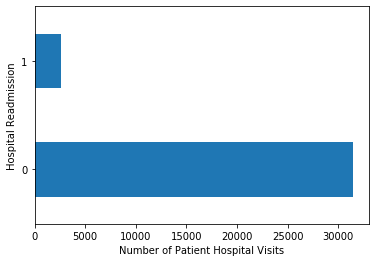

In [87]:
visit_plot = train_data.IS_READMISSION.value_counts().plot(kind = 'barh')
visit_plot.set_xlabel('Number of Patient Hospital Visits')
visit_plot.set_ylabel('Hospital Readmission')

# Patient Representation

In [1]:
import pandas as pd
import numpy as np
import random
import re

In [2]:
data =pd.read_csv("./train.csv", index_col = None)

In [3]:
data.columns = [re.sub(r"[,.;@#?!&$]+\ *", " ",x).replace('/\s\s+/g', ' ').replace(" ","_") for x in data.columns]

In [4]:
num_cols = ['AGE', 'ELIXHAUSER_SID30', 'mean_Diastolic_BP', 'mean_Glucose',
       'mean_Heart_Rate', 'mean_Resp_Rate', 'mean_Systolic_BP',
       'mean_Temperature', 'std_Diastolic_BP', 'std_Glucose', 'std_Heart_Rate',
       'std_Resp_Rate', 'std_Systolic_BP', 'std_Temperature', 'mean_Albumin',
       'mean_Calcium_Total', 'mean_Hematocrit', 'mean_Platelet_Count',
       'mean_Potassium', 'mean_Sodium', 'std_Albumin', 'std_Calcium_Total',
       'std_Hematocrit', 'std_Platelet_Count', 'std_Potassium', 'std_Sodium']

In [5]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data_minmax = min_max_scaler.fit(data[num_cols])

data_num = data_minmax.transform(data[num_cols])

data_scaled = pd.concat([pd.DataFrame(data_num, columns = num_cols), 
                   data[['INSURANCE', 'ETHNICITY', 'GENDER', 'FIRST_CAREUNIT','IS_READMISSION']]],
                 axis = 1)

In [8]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(data_scaled, test_size=0.2)

In [19]:
import os
import random
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers

tf.keras.backend.set_floatx('float32')
tf.random.set_seed(123)
np.random.seed(123)
random.seed(123)
os.environ['PYTHONHASHSEED']=str(123)

def df_to_dataset(dataframe, target_col_name, shuffle=True, batch_size=32, autoenc=True):
    """
    A utility method to create a tf.data dataset from a Pandas Dataframe
    """
    dataframe = dataframe.copy()
    labels = dataframe.pop(target_col_name)
    
    if autoenc:
        ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), feature_layer(dict(dataframe)).numpy()))
    else:
        ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [10]:
# Note:- Although for encoder target column doesn't make sense, the function is kept generic for later use as well.

In [11]:
# for feature_batch, label_batch in train_ds.take(1):
#     print('Every feature:', list(feature_batch.keys()))
#     print('A batch of ages:', feature_batch['AGE'])
#     print('A batch of targets:', label_batch )

In [12]:
feature_columns = []
# numeric cols
for numeric_cols in num_cols:    
    feature_columns.append(feature_column.numeric_column(numeric_cols))

# categorical cols
for cat_cols in ['INSURANCE', 'ETHNICITY', 'GENDER', 'FIRST_CAREUNIT']:
    categorical_column = feature_column.categorical_column_with_vocabulary_list(
      cat_cols, train[cat_cols].unique())
    indicator_column = feature_column.indicator_column(categorical_column)
    feature_columns.append(indicator_column)
    

In [13]:
# After defining our feature layer we will create a layer to input them to our keras model. We will DenseFeatures layer for this
feature_layer = layers.DenseFeatures(feature_columns)

In [14]:
batch_size = 32 
train_ds = df_to_dataset(train, 
                         target_col_name='IS_READMISSION', batch_size=batch_size)
val_ds = df_to_dataset(val, 
                         target_col_name='IS_READMISSION', batch_size=batch_size)
full_ds = df_to_dataset(data_scaled, 
                         target_col_name='IS_READMISSION', 
                        batch_size=batch_size,
                       shuffle = False)

In [15]:
# To modularize the shape of output layer in the autoencoder
output_shape = feature_layer(next(iter(train_ds))[0]).numpy().shape[1]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [16]:
encoder = tf.keras.Sequential([
    feature_layer,
    layers.Dense(32, activation = "selu", kernel_initializer="lecun_normal"),
    layers.Dense(16, activation = "selu", kernel_initializer="lecun_normal"),
    layers.Dense(8, activation = "selu", kernel_initializer="lecun_normal"),
    layers.Dense(4, activation = "selu", kernel_initializer="lecun_normal"),
    layers.Dense(2, activation = "selu", kernel_initializer="lecun_normal")
])

decoder = tf.keras.Sequential([
    layers.Dense(4, activation = "selu", kernel_initializer="lecun_normal", input_shape=[2]),
    layers.Dense(8, activation = "selu",kernel_initializer="lecun_normal"),
    layers.Dense(16, activation = "selu",kernel_initializer="lecun_normal"),
    layers.Dense(32, activation = "selu",kernel_initializer="lecun_normal"),
    layers.Dense(output_shape, activation = "selu", kernel_initializer="lecun_normal"),
])

stacked_ae = tf.keras.Sequential([encoder, decoder])
stacked_ae.compile(loss='mse', metrics = "mean_absolute_error",
                   optimizer= tf.keras.optimizers.Adam(learning_rate=0.01))

history = stacked_ae.fit(train_ds,
                         validation_data = val_ds,
                         epochs=15)

Epoch 1/15
853/853 [==============================] - 3s 3ms/step - loss: 0.0375 - mean_absolute_error: 0.1009 - val_loss: 0.0242 - val_mean_absolute_error: 0.0805
Epoch 2/15
853/853 [==============================] - 2s 3ms/step - loss: 0.0222 - mean_absolute_error: 0.0742 - val_loss: 0.0207 - val_mean_absolute_error: 0.0739
Epoch 3/15
853/853 [==============================] - 2s 3ms/step - loss: 0.0200 - mean_absolute_error: 0.0715 - val_loss: 0.0191 - val_mean_absolute_error: 0.0681
Epoch 4/15
853/853 [==============================] - 2s 3ms/step - loss: 0.0188 - mean_absolute_error: 0.0684 - val_loss: 0.0175 - val_mean_absolute_error: 0.0648
Epoch 5/15
853/853 [==============================] - 2s 3ms/step - loss: 0.0179 - mean_absolute_error: 0.0656 - val_loss: 0.0167 - val_mean_absolute_error: 0.0604
Epoch 6/15
853/853 [==============================] - 2s 3ms/step - loss: 0.0175 - mean_absolute_error: 0.0648 - val_loss: 0.0179 - val_mean_absolute_error: 0.0679
Epoch 7/15
853/8

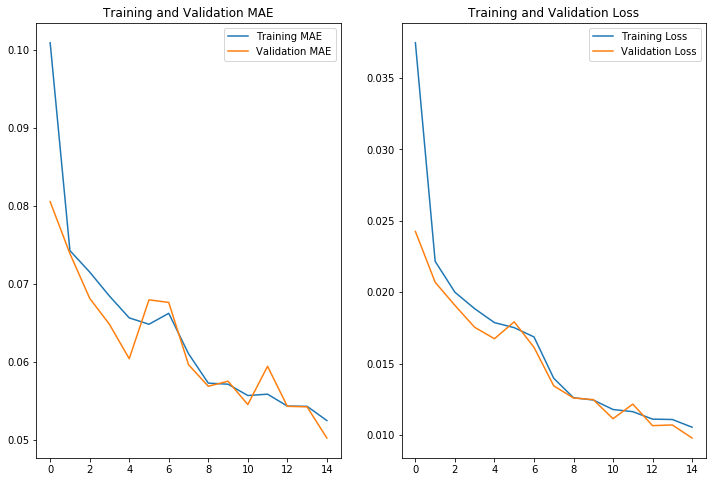

In [17]:
# Plotting libraries and parameters
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
import seaborn as sns

mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='upper right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
stacked_ae.save('trained_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: trained_model2\assets


# Cohort Discovery

In [19]:
codings = encoder.predict(full_ds)

In [103]:
k_means_data = pd.concat([data[["SUBJECT_ID","IS_READMISSION"]],
                          pd.DataFrame(codings, columns = ["val1","val2"])],
                         axis = 1)

In [ ]:
# ! pip install tabulate

In [151]:
from sklearn.cluster import KMeans
# Randomly choosing some value to begin experiments
k = 4
kmeans = KMeans(n_clusters=k, random_state=123)
cluster_predictions = kmeans.fit_predict(codings)

In [123]:
def plot_data(X, labels = k_means_data["IS_READMISSION"]):
    plt.scatter(X[:, 0], X[:, 1], c = labels, cmap='inferno')

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

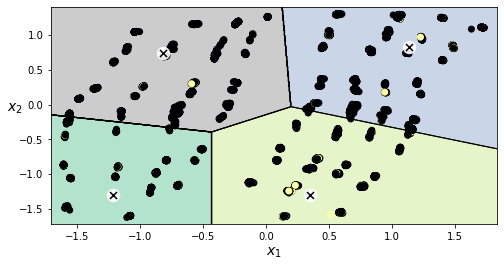

In [124]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, codings)
plt.show()

In [125]:
kmeans_iter1 = KMeans(n_clusters=4, init="k-means++", n_init=5,
                     max_iter=1, random_state=123)
kmeans_iter2 = KMeans(n_clusters=4, init="k-means++", n_init=5,
                     max_iter=2, random_state=123)
kmeans_iter3 = KMeans(n_clusters=4, init="k-means++", n_init=5,
                     max_iter=3, random_state=123)
kmeans_iter1.fit(codings)
kmeans_iter2.fit(codings)
kmeans_iter3.fit(codings)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=3,
       n_clusters=4, n_init=5, n_jobs=None, precompute_distances='auto',
       random_state=123, tol=0.0001, verbose=0)

#### Note the plotting code below is adapated from https://github.com/ageron/handson-ml2 

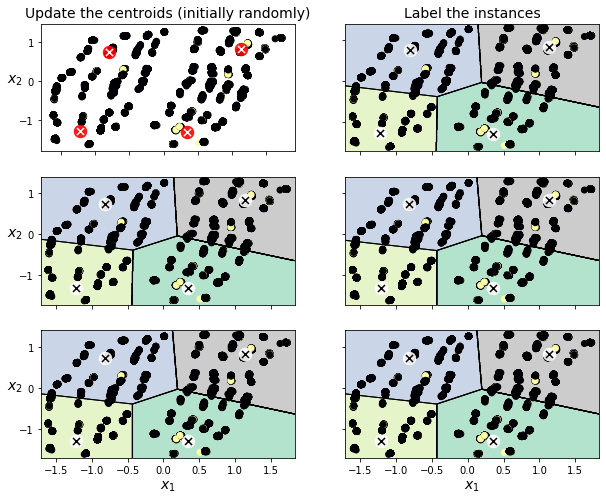

In [144]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(codings)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, codings, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, codings, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, codings, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, codings, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, codings, show_ylabels=False)

plt.show()

In [138]:
kmeans__ncluster = [KMeans(n_clusters=x, init="k-means++",
                           max_iter = 3,
                           n_init = 5,
                           random_state=123).fit(codings)
                for x in range(1, 10)]
inertias = [kmeans_model.inertia_ for kmeans_model in kmeans__ncluster]

In [130]:
from sklearn.metrics import silhouette_score
silhouette_scores = [silhouette_score(codings, kmeans_model.labels_)
                     for kmeans_model in kmeans__ncluster[1:]]

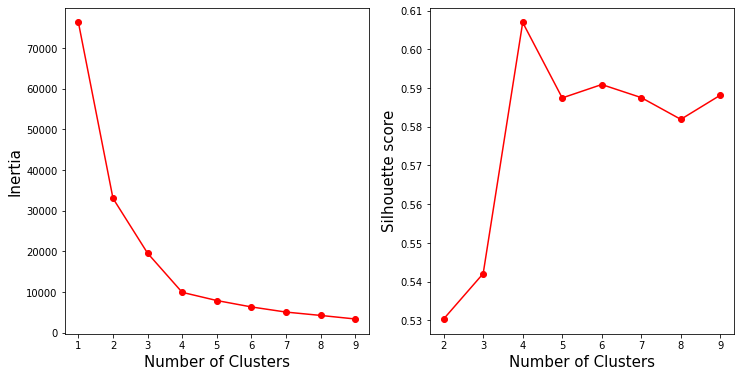

In [150]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(range(1, 10), inertias, "ro-")
plt.xlabel("Number of Clusters", fontsize=15)
plt.ylabel("Inertia", fontsize=15)

plt.subplot(122)
plt.plot(range(2, 10), silhouette_scores, "ro-")
plt.xlabel("Number of Clusters", fontsize=15)
plt.ylabel("Silhouette score", fontsize=15)
plt.show()

In [158]:
from sklearn.cluster import KMeans
# Randomly choosing some value to begin experiments
k = 4
kmeans = KMeans(n_clusters=k, init="k-means++", n_init=5, max_iter = 3, random_state=123)
cluster_predictions = kmeans.fit_predict(codings)

In [159]:
k_means_data["cluster_label"] = cluster_predictions

In [160]:
count_labels = k_means_data.groupby(['cluster_label','IS_READMISSION'])['SUBJECT_ID'].count().reset_index()
sample_count = pd.pivot_table(count_labels, index="cluster_label", columns=['IS_READMISSION'], values="SUBJECT_ID").reset_index()
sample_count.columns = [sample_count.columns.name + "_" +str(x) if type(x)!=str else x for x in list(sample_count.columns)] 
sample_count.reset_index(drop = True, inplace = True)
sample_count["Total_Samples"] = sample_count[["IS_READMISSION_0","IS_READMISSION_1"]].apply(sum, axis =1)
sample_count["Readmission_Percentage"] = (sample_count["IS_READMISSION_1"]/sample_count["Total_Samples"])*100

In [162]:
print(sample_count.to_markdown()) 

|    |   cluster_label |   IS_READMISSION_0 |   IS_READMISSION_1 |   Total_Samples |   Readmission_Percentage |
|---:|----------------:|-------------------:|-------------------:|----------------:|-------------------------:|
|  0 |               0 |               9357 |                918 |           10275 |                  8.93431 |
|  1 |               1 |               5098 |                380 |            5478 |                  6.93684 |
|  2 |               2 |               8892 |                743 |            9635 |                  7.71147 |
|  3 |               3 |               8149 |                562 |            8711 |                  6.45161 |


In [163]:
k_means_data.to_csv("cluster_label.csv")

# Multi Task Learning

In [1]:
import pandas as pd
import numpy as np

In [2]:
# data =pd.read_csv("./train.csv", index_col = None)

# data["cluster_labels"] = cluster_predictions

# data.columns = [re.sub(r"[,.;@#?!&$]+\ *", " ",x).replace('/\s\s+/g', ' ').replace(" ","_") for x in data.columns]

In [3]:
data = pd.read_csv("./train_w_labels.csv", index_col = None)

In [4]:
# Updating the num_cols and categorical_cols
num_cols = ['AGE', 'DISCHARGE_DURATION', 'ELIXHAUSER_SID30', 'mean_Diastolic_BP', 'mean_Glucose',
       'mean_Heart_Rate', 'mean_Resp_Rate', 'mean_Systolic_BP',
       'mean_Temperature', 'std_Diastolic_BP', 'std_Glucose', 'std_Heart_Rate',
       'std_Resp_Rate', 'std_Systolic_BP', 'std_Temperature', 'mean_Albumin',
       'mean_Calcium_Total', 'mean_Hematocrit', 'mean_Platelet_Count',
       'mean_Potassium', 'mean_Sodium', 'std_Albumin', 'std_Calcium_Total',
       'std_Hematocrit', 'std_Platelet_Count', 'std_Potassium', 'std_Sodium','LOS','TOTAL_TRANSFERS']
target_col = ['IS_READMISSION']
categorical_col = ['ADMISSION_TYPE','DISCHARGE_LOCATION','INSURANCE', 'ETHNICITY', 'GENDER', 'FIRST_CAREUNIT']

In [5]:
# Updating Scaling with new numerical columns
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data_minmax = min_max_scaler.fit(data[num_cols])

data_num = data_minmax.transform(data[num_cols])

data_scaled = pd.concat([pd.DataFrame(data_num, columns = num_cols), 
                   data[categorical_col + target_col + ["cluster_labels"]]],
                 axis = 1)

In [6]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(data_scaled, test_size=0.2)

In [7]:
def gen_labels(readm_val, cluster_val):
    """
    Helper function to generate labels for multi-output system
    """
    res = [0,0,0,0]
    if readm_val:
        res[cluster_val] = 1
    return res

In [8]:
# [[x[0] for x in labels], [x[1] for x in labels], [x[2] for x in labels],[x[3] for x in labels]]

In [9]:
# ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), [x[0] for x in labels], 
#                                             [x[1] for x in labels], [x[2] for x in labels],
#                                             [x[3] for x in labels]))

# ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), {'cluster_0':[x[0] for x in labels],
#                                                               'cluster_1':[x[1] for x in labels],
#                                                               'cluster_2':[x[2] for x in labels],
#                                                               'cluster_3':[x[3] for x in labels]}))

In [10]:
import os
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers

tf.keras.backend.set_floatx('float32')

feature_columns = []
feature_layer_inputs = {}
# numeric cols
for numeric_cols in num_cols:    
    feature_columns.append(feature_column.numeric_column(numeric_cols))
    feature_layer_inputs[numeric_cols] = tf.keras.Input(shape=(1,), name=numeric_cols)

# categorical cols
for cat_cols in categorical_col:
    categorical_column = feature_column.categorical_column_with_vocabulary_list(
      cat_cols, train[cat_cols].unique())
    indicator_column = feature_column.indicator_column(categorical_column)
    feature_columns.append(indicator_column)
    feature_layer_inputs[cat_cols] = tf.keras.Input(shape=(1,), name=cat_cols, dtype=tf.string)

# After defining our feature layer we will create a layer to input them to our keras model. We will DenseFeatures layer for this
feature_layer = layers.DenseFeatures(feature_columns)

In [11]:
def df_to_dataset_multio(dataframe, target_col_name = 'IS_READMISSION'):
    """
    A utility method to create a Input data for the MTL NN
    """
    dataframe = dataframe.copy()
    labels = [gen_labels(row[1], row[2]) for row in dataframe[[target_col_name, 'cluster_labels']].itertuples()]

    assert np.sum(labels) == dataframe[target_col_name].sum()
    dataframe.drop([target_col_name, 'cluster_labels'], axis = 1, inplace = True)

    # Generating Tensorflow Dataset
    train_ds = feature_layer(dict(dataframe)).numpy()
    y_train_ds = {'cluster_0':np.array([x[0] for x in labels]),
                  'cluster_1':np.array([x[1] for x in labels]),
                  'cluster_2':np.array([x[2] for x in labels]),
                  'cluster_3':np.array([x[3] for x in labels])}
    return train_ds, y_train_ds

train_ds, train_col_map = df_to_dataset_multio(train)
val_ds, val_col_map = df_to_dataset_multio(val)

In [12]:
def get_data_generator(df, cluster_map, batch_size=32):
    """
    Generator function which yields the input data and output for different clusters
    """
    feats, cluster_0, cluster_1, cluster_2, cluster_3 = [], [], [], [], []
    while True:
        for i in range(len(df)):
            feats.append(df[i])
            cluster_0.append(cluster_map['cluster_0'][i])
            cluster_1.append(cluster_map['cluster_1'][i])
            cluster_2.append(cluster_map['cluster_2'][i])
            cluster_3.append(cluster_map['cluster_3'][i])
            if len(feats) >= batch_size:
                yield np.array(feats), [np.array(cluster_0), np.array(cluster_1), np.array(cluster_2), np.array(cluster_3)]
                feats, cluster_0, cluster_1, cluster_2, cluster_3 = [], [], [], [], []

In [13]:
input_layer = layers.Input(shape = (train_ds.shape[1]))
_ = layers.Dense(32, activation = "selu", kernel_initializer="lecun_normal")(input_layer)
_ = layers.Dense(16, activation = "selu", kernel_initializer="lecun_normal")(_)
last_shared_layer = layers.Dense(8, activation = "selu", kernel_initializer="lecun_normal")(_)

_ = layers.Dense(4, activation = "selu", kernel_initializer="lecun_normal")(last_shared_layer)
cluster_0 = layers.Dense(1, activation = "sigmoid", name='cluster_0')(_)

_ = layers.Dense(4, activation = "selu", kernel_initializer="lecun_normal")(last_shared_layer)
cluster_1 = layers.Dense(1, activation = "sigmoid", name='cluster_1')(_)

_ = layers.Dense(4, activation = "selu", kernel_initializer="lecun_normal")(last_shared_layer)
cluster_2 = layers.Dense(1, activation = "sigmoid", name='cluster_2')(_)

_ = layers.Dense(4, activation = "selu", kernel_initializer="lecun_normal")(last_shared_layer)
cluster_3 = layers.Dense(1, activation = "sigmoid", name='cluster_3')(_)


mtl_model = tf.keras.Model(inputs = input_layer, 
                           outputs = [cluster_0, cluster_1, cluster_2, cluster_3])

mtl_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
              loss={'cluster_0': 'binary_crossentropy', 
                    'cluster_1': 'binary_crossentropy', 
                    'cluster_2': 'binary_crossentropy',
                    'cluster_3': 'binary_crossentropy'},
              loss_weights={'cluster_0': 0.25, 
                    'cluster_1': 0.25, 
                    'cluster_2': 0.25,
                    'cluster_3': 0.25},
              metrics={'cluster_0': 'AUC', 
                    'cluster_1': 'AUC', 
                    'cluster_2': 'AUC',
                    'cluster_3': 'AUC'})

batch_size = 32
valid_batch_size = 32
train_gen = get_data_generator(train_ds, train_col_map,  batch_size=batch_size)
valid_gen = get_data_generator(val_ds, val_col_map, batch_size=valid_batch_size)

history = mtl_model.fit_generator(train_gen,
                    steps_per_epoch=len(train)//batch_size,
                    epochs=10,
                    validation_data=valid_gen,
                    validation_steps=len(val)//valid_batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
852/852 [==============================] - 2s 2ms/step - loss: 0.0793 - cluster_0_loss: 0.1008 - cluster_1_loss: 0.0496 - cluster_2_loss: 0.0985 - cluster_3_loss: 0.0684 - cluster_0_auc: 0.8490 - cluster_1_auc_1: 0.8767 - cluster_2_auc_2: 0.7543 - cluster_3_auc_3: 0.8669 - val_loss: 0.0772 - val_cluster_0_loss: 0.0810 - val_cluster_1_loss: 0.0439 - val_cluster_2_loss: 0.1044 - val_cluster_3_loss: 0.0795 - val_cluster_0_auc: 0.8695 - val_cluster_1_auc_1: 0.9363 - val_cluster_2_auc_2: 0.8645 - val_cluster_3_auc_3: 0.8583
Epoch 2/10
852/852 [==============================] - 1s 2ms/step - loss: 0.0694 - cluster_0_loss: 0.0946 - cluster_1_loss: 0.0407 - cluster_2_loss: 0.0815 - cluster_3_loss: 0.0607 - cluster_0_auc: 0.8561 - cluster_1_auc_1: 0.9218 - cluster_2_auc_2: 0.8709 - cluster_3_auc_3: 0.9071 - val_loss: 0.0763 - val

In [16]:
from tensorflow.keras.layers import Layer
mtl_model._layers = [
    layer for layer in mtl_model._layers if isinstance(layer, Layer)
]

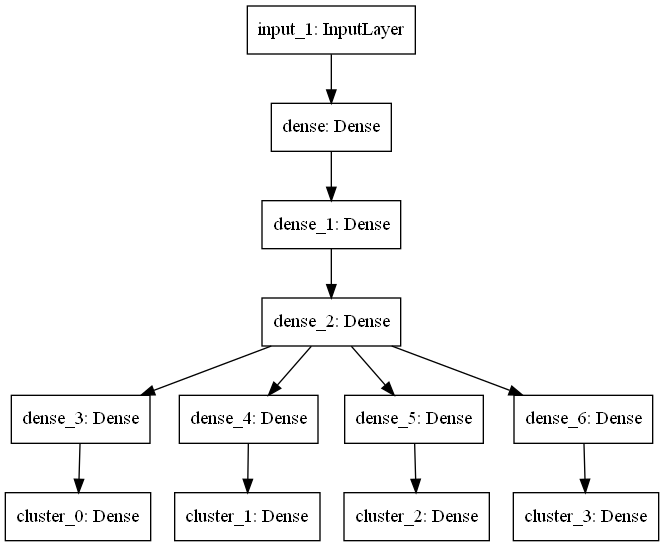

In [17]:
tf.keras.utils.plot_model(mtl_model)

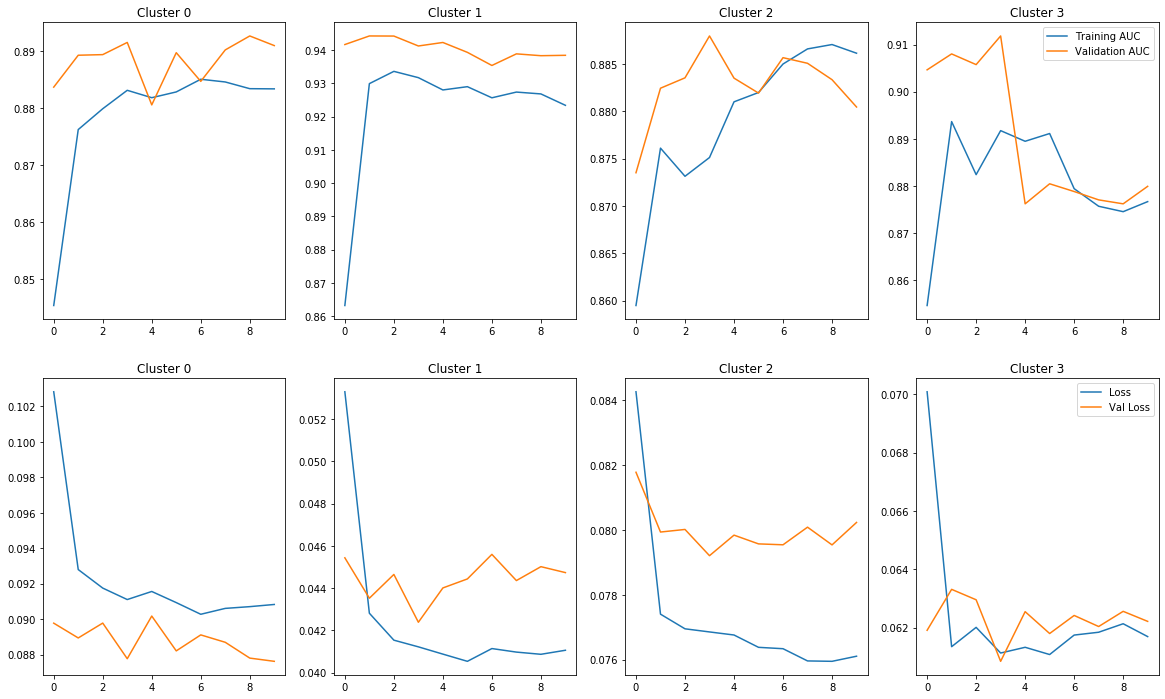

In [39]:
# Plotting libraries and parameters
import matplotlib.pyplot as plt
plt.figure(figsize=(20,12))
import seaborn as sns

epochs_range = range(10)

plt.subplot(2, 4, 1)
plt.plot(epochs_range, history.history['cluster_0_auc'], label='Training AUC')
plt.plot(epochs_range, history.history['val_cluster_0_auc'], label='Validation AUC')
# plt.legend(loc='upper right')
plt.title('Cluster 0')

plt.subplot(2, 4, 2)
plt.plot(epochs_range, history.history['cluster_1_auc_1'], label='Training AUC')
plt.plot(epochs_range, history.history['val_cluster_1_auc_1'], label='Validation AUC')
# plt.legend(loc='upper right')
plt.title('Cluster 1')

plt.subplot(2, 4, 3)
plt.plot(epochs_range, history.history['cluster_2_auc_2'], label='Training AUC')
plt.plot(epochs_range, history.history['val_cluster_2_auc_2'], label='Validation AUC')
# plt.legend(loc='upper right')
plt.title('Cluster 2')

plt.subplot(2, 4, 4)
plt.plot(epochs_range, history.history['cluster_3_auc_3'], label='Training AUC')
plt.plot(epochs_range, history.history['val_cluster_3_auc_3'], label='Validation AUC')
plt.legend(loc='upper right')
plt.title('Cluster 3')

plt.subplot(2, 4, 5)
plt.plot(epochs_range, history.history['cluster_0_loss'], label='Cluster 0 :- Loss')
plt.plot(epochs_range, history.history['val_cluster_0_loss'], label='Cluster 0:- Val Loss')
# plt.legend(loc='upper right')
plt.title('Cluster 0')

plt.subplot(2, 4, 6)
plt.plot(epochs_range, history.history['cluster_1_loss'], label='Cluster 1 :- Loss')
plt.plot(epochs_range, history.history['val_cluster_1_loss'], label='Cluster 1:- Val Loss')
# plt.legend(loc='upper right')
plt.title('Cluster 1')

plt.subplot(2, 4, 7)
plt.plot(epochs_range, history.history['cluster_2_loss'], label='Cluster 2 :- Loss')
plt.plot(epochs_range, history.history['val_cluster_2_loss'], label='Cluster 2:- Val Loss')
# plt.legend(loc='upper right')
plt.title('Cluster 2')

plt.subplot(2, 4, 8)
plt.plot(epochs_range, history.history['cluster_3_loss'], label='Loss')
plt.plot(epochs_range, history.history['val_cluster_3_loss'], label='Val Loss')
plt.legend(loc='upper right')
plt.title('Cluster 3')
plt.show()

In [30]:
mtl_model.save('trained_model_mtl')

INFO:tensorflow:Assets written to: trained_model_mtl\assets
